In [1]:
import numpy as np
import os
import yaml
import pickle
import csv
import matplotlib
import h5py
import json

import torch
from torch.utils.data import DataLoader
import numpy as np # 1.19.0
import matplotlib.ticker as ticker
import torchvision
from scipy import stats
import matplotlib.patches as mpatches
from functools import partial
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer
import scipy
from tqdm import tqdm_notebook as tqdm
from pesummary.gw.file.strain import StrainData
import bilby
import pandas as pd
from pprint import pprint

import dingo.gw.dataset.generate_dataset 
from dingo.gw.dataset import WaveformDataset
import dingo.gw.training.train_builders
from dingo.gw.ASD_dataset.noise_dataset import ASDDataset
from dingo.gw.waveform_generator import WaveformGenerator, sum_contributions_m
from dingo.gw.domains import build_domain, build_domain_from_model_metadata
import dingo.gw.inference
from dingo.gw.inference.data_preparation import data_to_domain, get_event_data_and_domain, parse_settings_for_raw_data, load_raw_data
from dingo.gw.gwutils import get_window_factor
from dingo.gw.transforms import *
from dingo.core.models import PosteriorModel
from dingo.gw.inference import injection
from dingo.gw.inference.gw_samplers import GWSamplerGNPE, GWSampler


%matplotlib inline
%load_ext autoreload
%autoreload 2

/data/nihargupte/projects/dingo-devel/tgr_venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
charizard_hex = ('#cd5241', '#084152', '#eede7b', '#207394', '#eeb45a', '#e64110', '#ff524a', '#f6a410', '#08398b', '#626262', '#833118')
plt.rcParams['text.usetex'] = False
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['font.size'] = 15
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=charizard_hex)

In [3]:
# asd_dataset = ASDDataset(file_name= "/data/nihargupte/datasets/ASDs/O3/2048/asds_O3.hdf5")
# asds = {k:np.array([v[100]]) for k, v in asd_dataset.asds.items()}
# print(asds)
# settings = asd_dataset.settings
# gps_times = {k:v[100] for k,v in asd_dataset.gps_times.items()}
# print(gps_times)

# dct = {
#     "asds": asds,
#     "settings": settings,
#     "gps_times": gps_times
# }
# fixed_asd_dataset = ASDDataset(dictionary=dct)
# fixed_asd_dataset.to_file(file_name="/data/nihargupte/datasets/ASDs/O3/2048/asds_O3_fixed_HLV.hdf5")

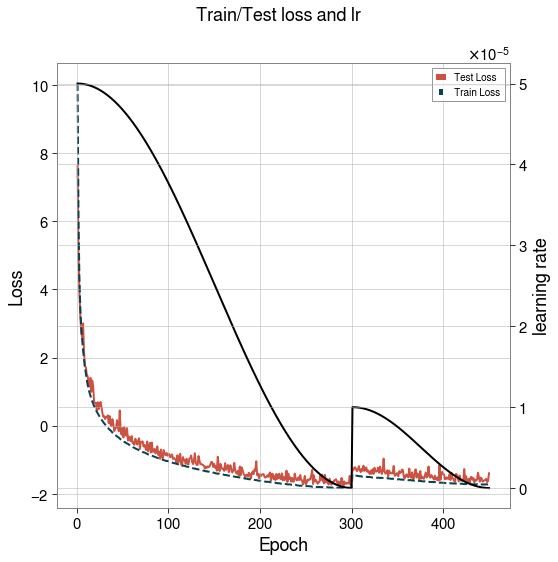

In [4]:
df = pd.read_csv("/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/train_dir_SEOBNRv4HM_PA_O3_1600_HLV/history.txt", delimiter='\t', header=None)
df.columns = ['epoch', 'train_loss', 'test_loss', '*learning_rates']


fig, ax1 = plt.subplots(figsize=(8, 8))
fig.suptitle("Train/Test loss and lr")

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(df['epoch'], df['test_loss'], label='Test Loss', linewidth=2)
ax1.plot(df['epoch'], df['train_loss'], label='Train Loss', linestyle='--', linewidth=2)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate')  # we already handled the x-label with ax1
ax2.plot(df['epoch'], df['*learning_rates'], label='lr', c='k', linewidth=2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend()

In [41]:
with open("/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/train_dir_SEOBNRv4HM_PA_O1_2048/metadata.yaml") as f:
    main_pm_metadata = yaml.safe_load(f)

In [5]:
torch.cuda.set_device(7)

# build posterior model
# For O1 you want to use model_stage_1
main_pm = PosteriorModel(
    device="cuda",
    **{"model_filename": "/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/train_dir_SEOBNRv4HM_PA_O1_2048/model_stage_1.pt"},
    load_training_info=False
)

time_pm = PosteriorModel(
    device='cuda',
    **{"model_filename": "/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/train_dir_SEOBNRv4HM_PA_O1_2048_time/model_latest.pt"},
    load_training_info=False
)

Putting posterior model to device cuda.
Putting posterior model to device cuda.


Injections
----------

In [11]:
# Generating an injection for the network to do inference on
injection_generator = injection.Injection.from_posterior_model_metadata(main_pm.metadata)

# Opening up a asd
# asd_dataset = ASDDataset(file_name= "/data/nihargupte/datasets/ASDs/old_asds/asds_O1.hdf5")
asd_dataset = ASDDataset(file_name= "/data/nihargupte/datasets/ASDs/O3/2048/asds_O3.hdf5")
asd = asd_dataset.sample_random_asds()
injection_generator.asd = asd
injection_generator.whiten = False

intrinsic_parameters = {
    # intrinsic parameters
    "chirp_mass": 30.2,
    "mass_ratio": 0.79,
    "chi_1": .32,
    "chi_2": .57,
    "domega220": 0,
    "dtau220": 0, 
}

extrinsic_parameters = {
    'phase': 0,
    'theta_jn': 0,
    'geocent_time': 0,
    'luminosity_distance': 450,
    'ra': 0,
    'dec': 0,
    'psi': 0,
}

theta = {**intrinsic_parameters, **extrinsic_parameters}

# Investigate injection class
# Backwards compatability
main_pm.metadata["dataset_settings"]["waveform_generator"]["spin_conversion_phase"] = 0 
domain = build_domain_from_model_metadata(main_pm.metadata)
strain_data = injection_generator.injection(theta)

Setting spin_conversion_phase = 0. Using this value for the phase parameter for conversion to cartesian spins.

Loading dataset from /data/nihargupte/datasets/ASDs/O3/2048/asds_O3.hdf5.


In [12]:
theta = strain_data["parameters"].copy()
init_sampler = GWSampler(model=time_pm)
sampler = GWSamplerGNPE(model=main_pm, init_sampler=init_sampler, num_iterations=30)
sampler.context = strain_data
sampler.run_sampler(
    num_samples=50_000,
    batch_size=10_000,
)
# total_mass = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(sampler.samples["chirp_mass"], sampler.samples["mass_ratio"])
# mass_1, mass_2 = bilby.gw.conversion.total_mass_and_mass_ratio_to_component_masses(sampler.samples["mass_ratio"], total_mass)
# sampler.samples["mass_1"] = mass_1
# sampler.samples["mass_2"] = mass_2

GNPE parameters:  ['H1_time', 'L1_time', 'V1_time']
Running sampler to generate 50000 samples.
it 0.	proxy mean:  0.01238 0.01618 -0.00823 	proxy std: 0.00267 0.00270 0.00440
it 1.	proxy mean:  0.01257 0.01621 -0.00781 	proxy std: 0.00255 0.00253 0.00427
it 2.	proxy mean:  0.01275 0.01639 -0.00755 	proxy std: 0.00242 0.00239 0.00415
it 3.	proxy mean:  0.01295 0.01657 -0.00734 	proxy std: 0.00230 0.00225 0.00405
it 4.	proxy mean:  0.01311 0.01673 -0.00714 	proxy std: 0.00218 0.00214 0.00395
it 5.	proxy mean:  0.01326 0.01689 -0.00697 	proxy std: 0.00208 0.00202 0.00389
it 6.	proxy mean:  0.01340 0.01702 -0.00682 	proxy std: 0.00198 0.00192 0.00382
it 7.	proxy mean:  0.01354 0.01716 -0.00666 	proxy std: 0.00190 0.00182 0.00376
it 8.	proxy mean:  0.01365 0.01727 -0.00653 	proxy std: 0.00181 0.00175 0.00370
it 9.	proxy mean:  0.01376 0.01736 -0.00641 	proxy std: 0.00174 0.00167 0.00364
it 10.	proxy mean:  0.01385 0.01746 -0.00632 	proxy std: 0.00168 0.00160 0.00360
it 11.	proxy mean:  0.01

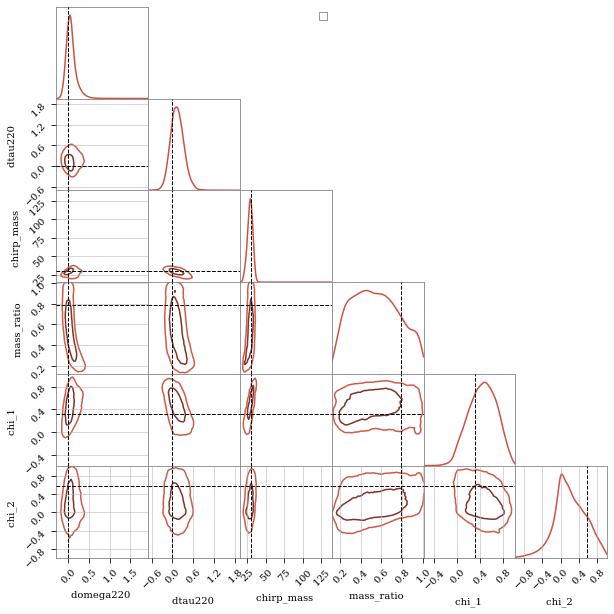

In [13]:
labels = ["domega220", "dtau220", "chirp_mass", "mass_ratio", "chi_1", "chi_2"]

N = 1
c = ChainConsumer()
c.add_chain(sampler.samples[labels], color=charizard_hex[0], name='dingo')
# c.add_chain(bilby_sampler.samples[labels], color=charizard_hex[0], name='bilby')

c.configure(
    linestyles=["-"] * N,
    linewidths=[1.5] * N,
    sigmas=[np.sqrt(2) * scipy.special.erfinv(x) for x in [0.5, 0.9]],
    shade=[False] + [True] * (N - 1),
    shade_alpha=0.3,
    bar_shade=False,
    label_font_size=10,
    tick_font_size=10,
    usetex=False,
    legend_kwargs={"fontsize": 30},
    kde=0.7
)

fig = c.plotter.plot(truth=theta)# , filename=f'/home/local/nihargupte/dingo-devel/tutorials/06_tgr/plots/SEOBNRv4HM_PA_injection_4.png')
ax = fig.axes[2]
# ax.scatter(bilby_sampler.samples["domega220"].to_numpy(), bilby_sampler.samples["dtau220"].to_numpy())
ax.legend()

Loading Event Data
------------------

In [31]:
# Opening up lalinference data

# Also loading lalinference domega220 and dtau220 values
event = "GW150914"
try:
    domega220 = np.loadtxt(f"/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/datasets/posteriors/gwtc-3-paper/{event}/rin_{event}_pseobnrv4hm_domega_220.dat.gz")
    dtau220 = np.loadtxt(f"/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/datasets/posteriors/gwtc-3-paper/{event}/rin_{event}_pseobnrv4hm_dtau_220.dat.gz")
    lalinference_samples = pd.DataFrame(data=np.stack([domega220, dtau220]).T, columns=["domega220", "dtau220"])
    print(lalinference_samples.shape)
except:
    print(f"TGR results not found for {event}")

# Alternate method load from hypatia full posterior
lalinference_samples = pd.read_csv(f"/home/nihargupte.HYPATIA/runs/LVK_analysis/{event}/posterior_samples.dat", sep=r"\t")
print(lalinference_samples.shape)

# file = f"/home/nihargupte.HYPATIA/runs/LVK_analysis/GW150914/posterior_samples.dat"
# prod_lalinference_samples = pd.read_csv(file, sep=r"\t")
file = f"/home/nihargupte.HYPATIA/runs/GW150914_4/cbcBayes/posterior_samples.dat"
lalinference_samples = pd.read_csv(file, sep=r"\t")
# print("Posterior results not found on hypatia")
print(lalinference_samples.shape)

(44052, 2)


/tmp/ipykernel_3338543/849374409.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  lalinference_samples = pd.read_csv(f"/home/nihargupte.HYPATIA/runs/LVK_analysis/{event}/posterior_samples.dat", sep=r"\t")


(44052, 140)


/tmp/ipykernel_3338543/849374409.py:20: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  lalinference_samples = pd.read_csv(file, sep=r"\t")


(28153, 78)


In [17]:
# Loading the data that we got from the LALInference run instead of just specifying the GPS time
from gwpy.timeseries import TimeSeries
from lalframe.frread import read_timeseries
lalinference_psd_H1 = np.genfromtxt("/home/nihargupte.HYPATIA/runs/GW150914_2/engine/lalinferencemcmc-0-H1L1-1126259462.391-1.hdf5H1-PSD.dat")
lalinference_psd_L1 = np.genfromtxt("/home/nihargupte.HYPATIA/runs/GW150914_2/engine/lalinferencemcmc-0-H1L1-1126259462.391-1.hdf5L1-PSD.dat")
# Copied directly from LALinference run except had to move where the file was since saraswati can't access HYPATIA localhost

# source = "/home/nihargupte.HYPATIA/data/frame_files/GW150914/L-L1_HOFT_C02_CACHE-1126259184-297.lcf"
# source = lal.CacheImport(os.path.expanduser(source))
# print(dir(source))
# L1_data = read_timeseries(source=source, channel="L1:DCS-CALIB_STRAIN_C02")
lalinference_strain_data_L1 = TimeSeries.read("/home/nihargupte.HYPATIA/data/frame_files/GW150914/L-L1_HOFT_C02-1126256640-4096.gwf", "L1:DCS-CALIB_STRAIN_C02")
lalinference_strain_data_H1 = TimeSeries.read("/home/nihargupte.HYPATIA/data/frame_files/GW150914/H-H1_HOFT_C02-1126256640-4096.gwf", "H1:DCS-CALIB_STRAIN_C02")
lal_strain = {"H1": lalinference_strain_data_H1, "L1": lalinference_strain_data_L1}

# Trimming to match our event time and buffer time
time_psd = 1024
time_buffer = 2.0
time_event = 1126259462.391

# lalinference_strain_data_L1.plot()
settings_raw_data = parse_settings_for_raw_data(main_pm.metadata, time_psd, time_buffer)
start_time = time_event + time_buffer - settings_raw_data["time_segment"]
end_time = time_event + time_buffer
print(start_time, end_time)

# Resampling to 4096, note this applies some windowing so I'm not entirely sure of the results
for ifo_name, strain in lal_strain.items():
    strain = strain.resample(rate=4096)
    slice_idxs = [np.argmin(np.abs(np.array(strain.times) - start_time)), np.argmin(np.abs(np.array(strain.times) - end_time))]
    trimmed_strain = strain[slice_idxs[0]:slice_idxs[1]]
    lal_strain[ifo_name] = trimmed_strain

init_sampler = GWSampler(model=time_pm)
sampler = GWSamplerGNPE(model=main_pm, init_sampler=init_sampler, num_iterations=30)
sampler.base_model_metadata["dataset_settings"]["waveform_generator"]["spin_conversion_phase"] = 0 

1126259456.391 1126259464.391
GNPE parameters:  ['H1_time', 'L1_time']


In [18]:
# raw_data = load_raw_data(1126259462.391, settings=settings_raw_data)
raw_data = {
    "strain":None,
    "psd": {"H1": None, "L1": None}
}
raw_data["strain"] = lal_strain
raw_data["psd"]["H1"] = lalinference_psd_H1[:, 1]
raw_data["psd"]["L1"] = lalinference_psd_L1[:, 1]


# step 2: prepare the data for the network domain
domain = build_domain_from_model_metadata(main_pm.metadata)
lal_event_data = data_to_domain(
    raw_data,
    settings_raw_data,
    domain,
    window=main_pm.metadata["train_settings"]["data"]["window"],
)


Loading dataset from /data/nihargupte/datasets/ASDs/O3/2048/asds_O3.hdf5.
<class 'numpy.float32'>


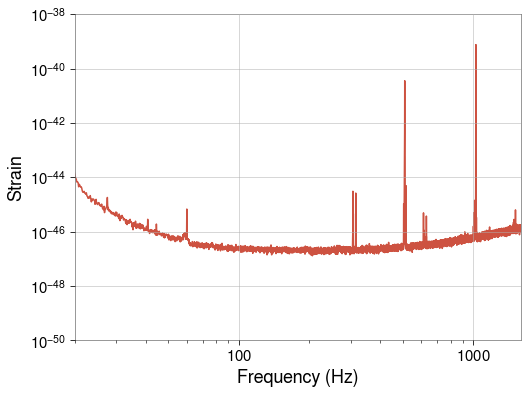

In [20]:
asd_dataset = ASDDataset(file_name= "/data/nihargupte/datasets/ASDs/O3/2048/asds_O3.hdf5")
asd = asd_dataset.sample_random_asds()

plt.figure(figsize=(8, 6))
plt.yscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain")
plt.xlim([20, 1600])
plt.xscale('log')
print(type(domain.sample_frequencies[0]))
simulated_psd = [lal.LIGOIPsd(float(f)) for f in domain.sample_frequencies]
plt.ylim([1e-50, 1e-38])
# plt.plot(domain.sample_frequencies, simulated_psd, label='lal simulated')
# plt.plot(domain.sample_frequencies, lalinference_psd_L1[:, 1], label='lal')
# plt.plot([1600, 1600], [1e-50, 1e-40])
plt.plot(domain.sample_frequencies, asd["L1"]**2)

Importance Sampling + Synethetic Phase
======================================

In [6]:
init_sampler = GWSampler(model=time_pm)
sampler = GWSamplerGNPE(model=main_pm, init_sampler=init_sampler, num_iterations=130)

time_psd = 1024
time_buffer = 2.0
time_event = 1266618172.4

event_data, domain = get_event_data_and_domain(main_pm.metadata, time_event, time_psd, time_buffer)
sampler.context = event_data

sampler.event_metadata = {
    "time_event": time_event,
    "time_psd": time_psd,
    "time_buffer": time_buffer,
}

GNPE parameters:  ['H1_time', 'L1_time', 'V1_time']


<class 'numpy.float32'>


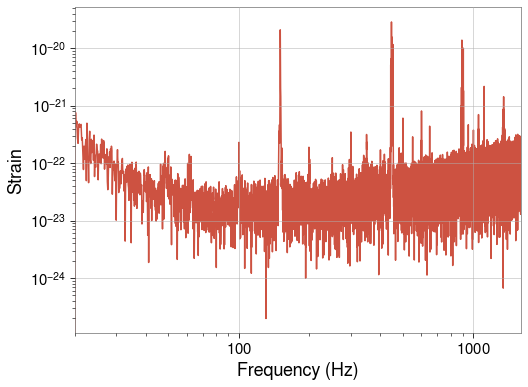

In [7]:
plt.figure(figsize=(8, 6))
plt.yscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain")
plt.xlim([20, 1600])
plt.xscale('log')
print(type(domain.sample_frequencies[0]))
# plt.ylim([1e-50, 1e-38])

plt.plot(domain.sample_frequencies, np.abs(event_data["waveform"]["V1"]))

In [ ]:
# Importance sampling 
sampler.context = event_data
sampler.run_sampler(num_samples=1_500_000, batch_size=5_000)
sampler.samples = sampler.samples.drop(columns=[param for param in sampler.samples.columns  if "GNPE:" in param])

Running sampler to generate 1500000 samples.
it 0.	proxy mean:  -0.00113 -0.00329 -0.01601 	proxy std: 0.00280 0.00295 0.01526
it 1.	proxy mean:  -0.00112 -0.00317 -0.01611 	proxy std: 0.00280 0.00276 0.01530
it 2.	proxy mean:  -0.00113 -0.00311 -0.01615 	proxy std: 0.00275 0.00272 0.01530
it 3.	proxy mean:  -0.00109 -0.00308 -0.01619 	proxy std: 0.00269 0.00268 0.01530
it 4.	proxy mean:  -0.00108 -0.00305 -0.01623 	proxy std: 0.00266 0.00260 0.01528
it 5.	proxy mean:  -0.00106 -0.00303 -0.01625 	proxy std: 0.00262 0.00256 0.01525
it 6.	proxy mean:  -0.00107 -0.00302 -0.01625 	proxy std: 0.00259 0.00253 0.01524
it 7.	proxy mean:  -0.00104 -0.00303 -0.01627 	proxy std: 0.00257 0.00248 0.01522
it 8.	proxy mean:  -0.00106 -0.00302 -0.01626 	proxy std: 0.00254 0.00245 0.01521
it 9.	proxy mean:  -0.00107 -0.00301 -0.01629 	proxy std: 0.00250 0.00243 0.01520
it 10.	proxy mean:  -0.00106 -0.00303 -0.01632 	proxy std: 0.00248 0.00242 0.01518
it 11.	proxy mean:  -0.00108 -0.00304 -0.01633 	prox

In [8]:
# Save training samples
sampler.samples = sampler.samples.drop(columns=[param for param in sampler.samples.columns  if "GNPE:" in param or "phase"==param])
# Throw away phase because of synthetic phase NOTE should we could also marginalize over this but 
# sampler.metadata["train_settings"]["data"]["inference_parameters"].remove("phase")
sampler.base_model_metadata["dataset_settings"]["waveform_generator"]["spin_conversion_phase"] = 0 
outdir = f"/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/dumps/3_detector_O3/GW200224_222234_2/is"
os.makedirs(outdir)
sampler.to_hdf5(label="training_samples", outdir=outdir)

AttributeError: 'NoneType' object has no attribute 'drop'

In [9]:
# Load training samples
# sampler.metadata["train_settings"]["data"]["inference_parameters"].remove("phase")
sampler.base_model_metadata["dataset_settings"]["waveform_generator"]["spin_conversion_phase"] = 0 
labels = main_pm.metadata["train_settings"]["data"]["inference_parameters"].copy()
with h5py.File(f"{outdir}/dingo_samples_training_samples.hdf5", "r") as f:
    a = f["samples"].fields(labels)[:]
    arr = np.empty((a.shape[0], len(labels)))
    for i in range(a.shape[0]):
        arr[i, :] = list(a[i])

sampler.samples = pd.DataFrame(data=arr, columns=labels)
sampler.samples.shape

NameError: name 'outdir' is not defined

Training new nde for event 1266618172.4.
Putting posterior model to device cuda.

Start training epoch 1 with lr [0.000835]
Train Epoch: 1 [0/1350000 (0%)]		Loss: 18.886 (18.886)		Time Dataloader: 0.142 (0.142)		Time Network: 0.156 (0.156)
Train Epoch: 1 [4096/1350000 (0%)]		Loss: 17.788 (18.337)		Time Dataloader: 0.015 (0.079)		Time Network: 0.142 (0.149)
Train Epoch: 1 [8192/1350000 (1%)]		Loss: 16.424 (17.699)		Time Dataloader: 0.016 (0.058)		Time Network: 0.141 (0.146)
Train Epoch: 1 [12288/1350000 (1%)]		Loss: 16.076 (17.294)		Time Dataloader: 0.015 (0.047)		Time Network: 0.142 (0.145)
Train Epoch: 1 [16384/1350000 (1%)]		Loss: 15.553 (16.945)		Time Dataloader: 0.015 (0.041)		Time Network: 0.146 (0.145)
Train Epoch: 1 [20480/1350000 (2%)]		Loss: 14.826 (16.592)		Time Dataloader: 0.016 (0.036)		Time Network: 0.142 (0.145)
Train Epoch: 1 [24576/1350000 (2%)]		Loss: 14.383 (16.277)		Time Dataloader: 0.014 (0.033)		Time Network: 0.134 (0.143)
Train Epoch: 1 [28672/1350000 (2%)]		Loss:

/data/nihargupte/projects/dingo-devel/tgr_venv/lib/python3.8/site-packages/bilby/gw/conversion.py:547: RuntimeWarning: invalid value encountered in double_scalars
  return (mass_1 * mass_2) ** 0.6 / (mass_1 + mass_2) ** 0.2
/data/nihargupte/projects/dingo-devel/tgr_venv/lib/python3.8/site-packages/bilby/gw/conversion.py:547: RuntimeWarning: invalid value encountered in double_scalars
  return (mass_1 * mass_2) ** 0.6 / (mass_1 + mass_2) ** 0.2
/data/nihargupte/projects/dingo-devel/tgr_venv/lib/python3.8/site-packages/bilby/gw/conversion.py:547: RuntimeWarning: invalid value encountered in double_scalars
  return (mass_1 * mass_2) ** 0.6 / (mass_1 + mass_2) ** 0.2
/data/nihargupte/projects/dingo-devel/tgr_venv/lib/python3.8/site-packages/bilby/gw/conversion.py:547: RuntimeWarning: invalid value encountered in double_scalars
  return (mass_1 * mass_2) ** 0.6 / (mass_1 + mass_2) ** 0.2
/data/nihargupte/projects/dingo-devel/tgr_venv/lib/python3.8/site-packages/bilby/gw/conversion.py:547: R

Of 250000 samples, 4112 lie outside the prior. Dropping these.
Calculating 245888 likelihoods.
Done. This took 1205.60 seconds.
Number of samples: 245888
Log(evidence): -39347.643 +-0.024
Effective sample size: 1659.5 (0.67%)
Saving dataset to /data/nihargupte/projects/dingo-devel/tutorials/06_tgr/dumps/GW200224_222234_1/is/dingo_samples_weighted.hdf5
Plotting diagnostics.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/data/nihargupte/projects/dingo-devel/dingo/gw/waveform_generator/waveform_generator.py:196: UserWarning: Evaluating the waveform failed with error: Internal function call failed: Input domain error
The parameters were (2.590124778184188e+31, 2.0817099154982526e+31, 0.0, 0.0, -0.07671317458152771, 0.0, 0.0, 0.4766269028186798, 3.085677581491367e+24, 0.48387014865875244, 0.6008231247029338, 0.0, 0.0, 0.0, 0.125, 20.0, 2048.0, 20.0, <Swig Object of type 'tagLALDict *' at 0x7f3055a93930>, 95)

  warnings.warn(
XLAL Error - XLALSimIMRSpinAlignedEOBModes: Ringdown frequency > Nyquist frequency!
At present this situation is not supported.
XLAL Error - XLALSimIMRSpinAlignedEOBModes (LALSimIMRSpinAlignedEOB.c:1228): Input domain error
XLAL Error - XLALSimIMRSpinAlignedEOBWaveformAll (LALSimIMRSpinAlignedEOB.c:3822): Internal function call 

failed chi_1                    -0.076713
chi_2                     0.476627
chirp_mass               41.526112
geocent_time             -0.016433
luminosity_distance    1765.138306
domega220                 0.034800
dtau220                   0.002109
mass_ratio                0.803710
theta_jn                  0.483870
dec                      -0.070879
ra                        3.021831
psi                       2.585251
phase                     0.600823
Name: 237553, dtype: float64
Generating cornerplot with 95080 out of 245888 IS samples.


/data/nihargupte/projects/dingo-devel/tgr_venv/lib/python3.8/site-packages/chainconsumer/plotter.py:1186: UserWarning: No contour levels were found within the data range.
  con = ax.contour(x_centers, y_centers, vals, levels=levels, colors=colours2, linestyles=linestyle, linewidths=linewidth, zorder=zorder)


<Figure size 432x288 with 0 Axes>

<Figure size 1728x1152 with 0 Axes>

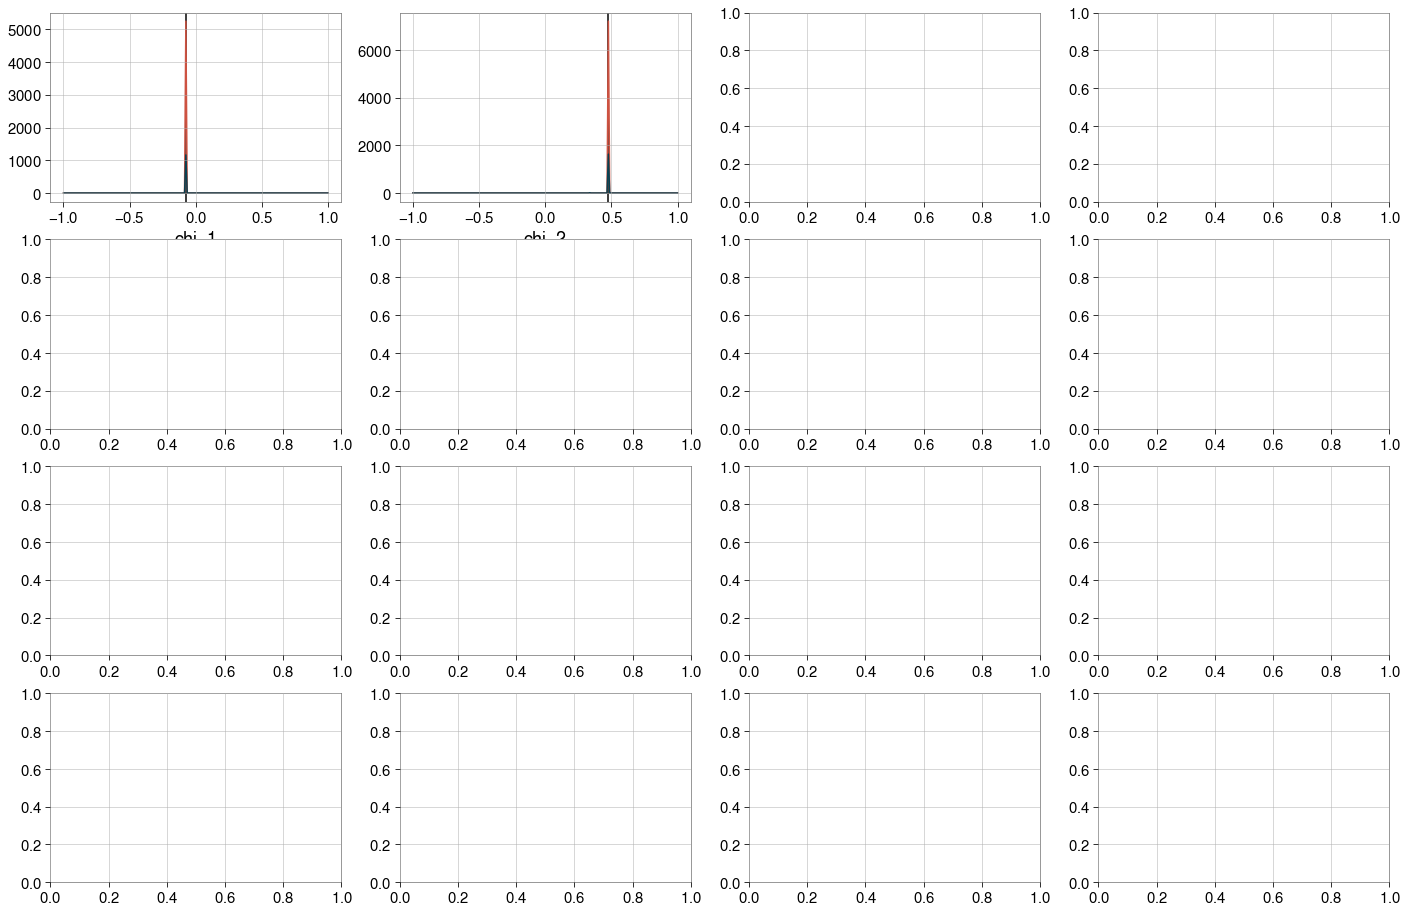

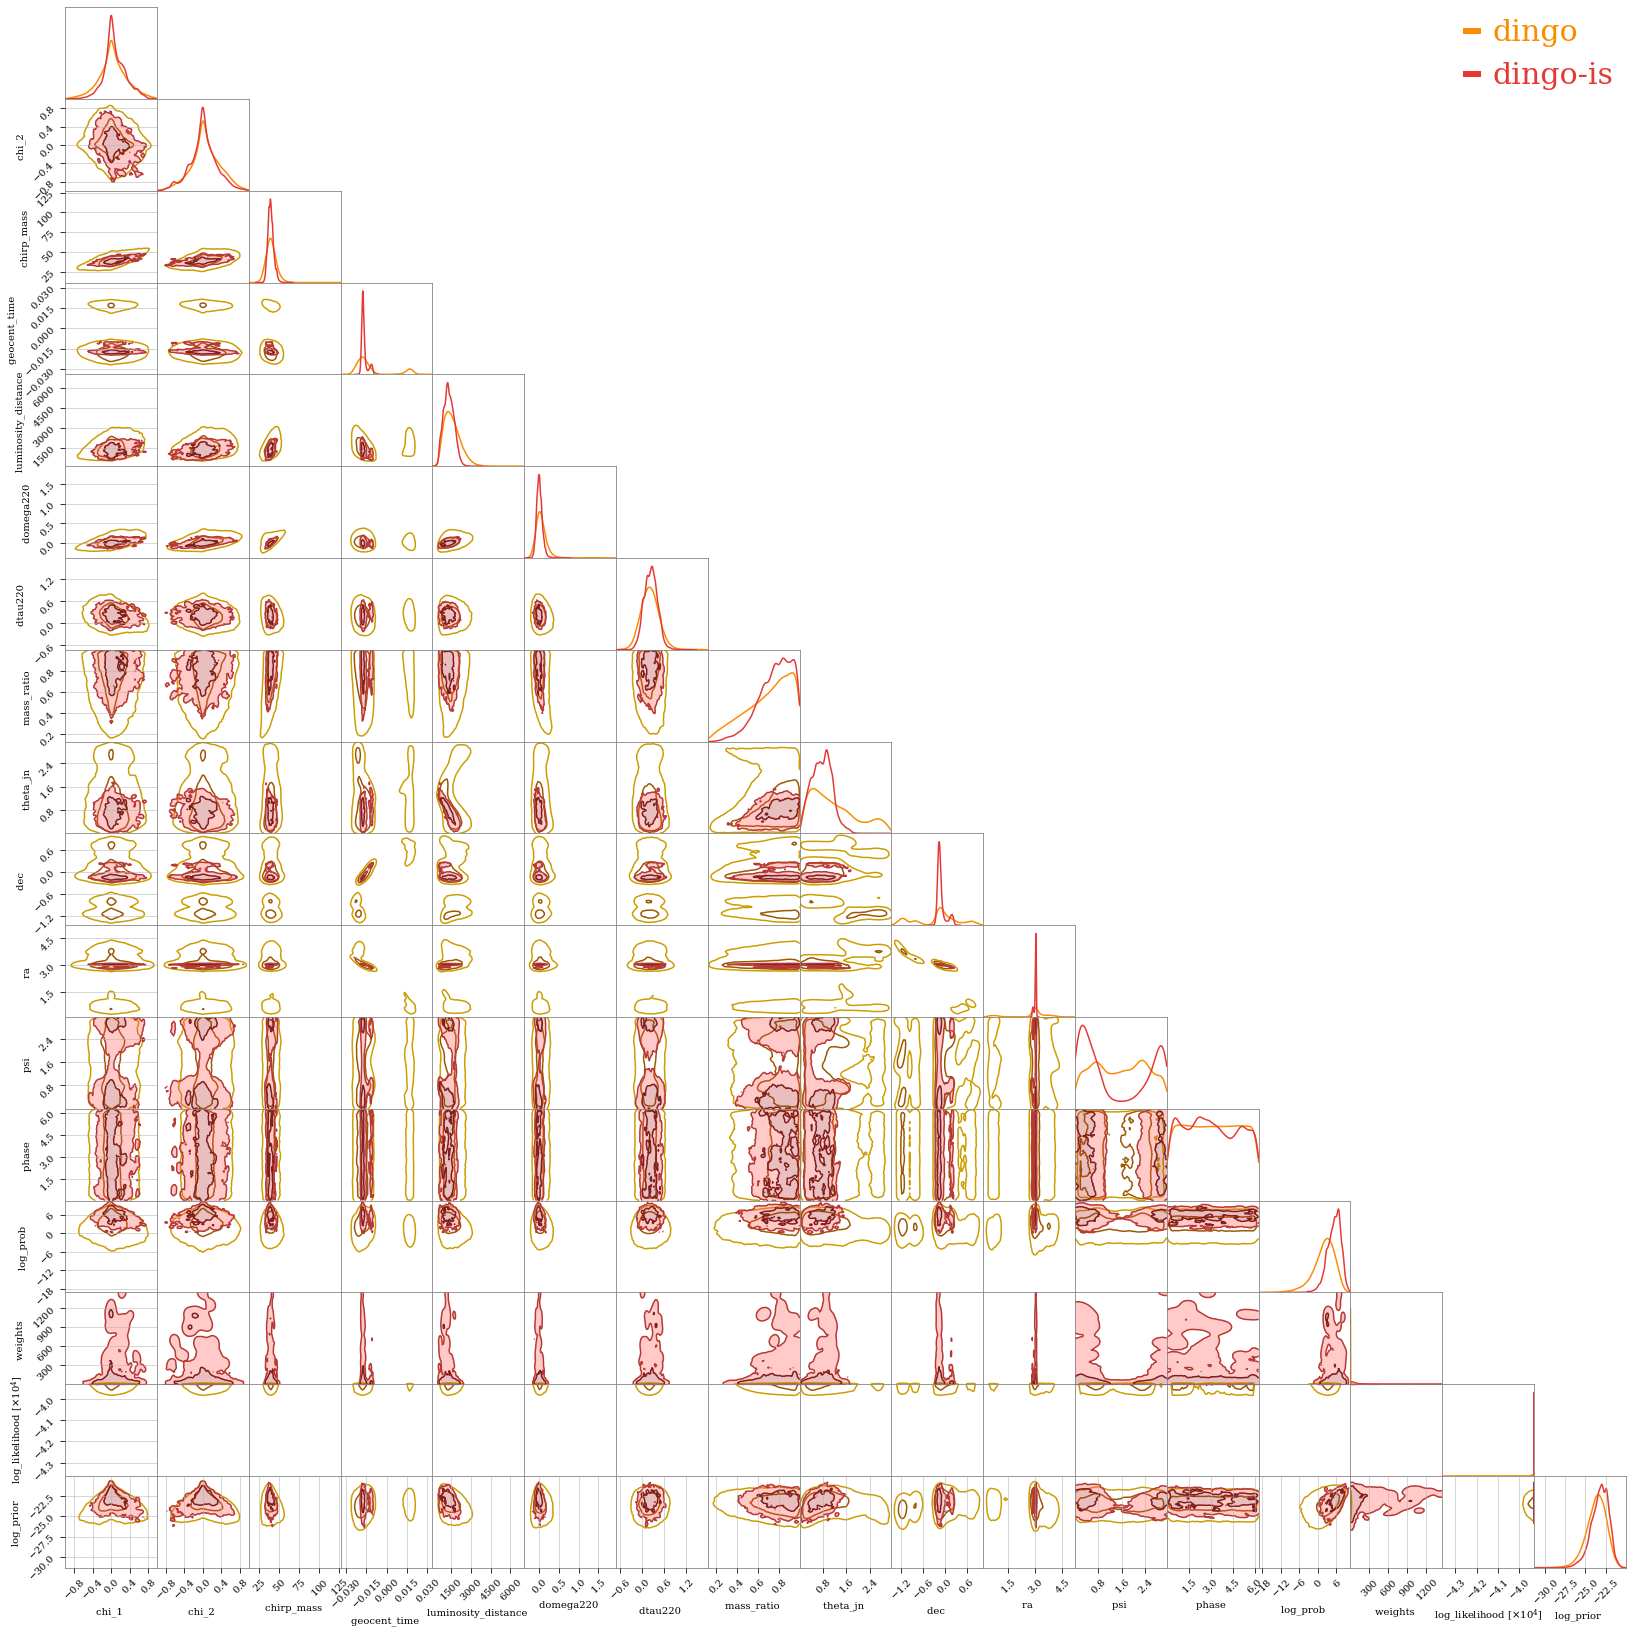

In [12]:
from dingo.core.samples_dataset import SamplesDataset
from dingo.gw.importance_sampling.importance_weights import importance_sample

# raise Exception("Check liklihoods getting properly evaluated")

sampler.metadata["event"] = {}
sampler.metadata["event"]["time_event"] = time_event
samples_dataset = SamplesDataset(
    dictionary={
        "samples": sampler.samples,
        "context": event_data,
        "settings": sampler.metadata,
    }
)
settings = {
    "num_samples": 50_000,
    "num_processes": 16,
    "slice_plots": {
        "num_slice_plots": 5,
        "params_slice2d": [["phase", "geocent_time"], ["phase", "chi_1"]],
    },
    "synthetic_phase": {
        "approximation_22_mode": False,
        "n_grid": 5001,
        "uniform_weight": 0.01,
        "num_processes": 16,
    },
    "nde": {
        "data": {"parameters": list(main_pm.metadata["train_settings"]["data"]["inference_parameters"].copy())},
        "model": {
            "type": "nsf",
            "num_flow_steps": 8,
            "base_transform_kwargs": {
                "hidden_dim": 128,
                "num_transform_blocks": 10,
                "activation": "elu",
                "dropout_probability": 0.1,
                "batch_norm": True,
                "num_bins": 8,
                "base_transform_type": "rq-coupling",
            },
        },
        "training": {
            "device": "cuda",
            "num_workers": 0,
            "train_fraction": 0.9,
            "batch_size": 4096,
            "epochs": 20,
            "optimizer": {"type": "adam", "lr": 0.000835},
            "scheduler": {"type": "cosine", "T_max": 20},
        },       
    },
}
importance_sample(settings, samples_dataset, outdir)

In [112]:
from dingo.gw.inference.gw_samplers import GWSamplerUnconditional
from dingo.core.samples_dataset import SamplesDataset

outdir = f"/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/dumps/2_detector_O3/GW200224_222234/is"
labels = main_pm_metadata["train_settings"]["data"]["inference_parameters"].copy()
labels.append("weights")
with h5py.File(outdir + "/dingo_samples_weighted.hdf5", "r") as f:
    a = f["samples"].fields(labels)[:]
    arr = np.empty((a.shape[0], len(labels)))
    for i in range(a.shape[0]):
        arr[i, :] = list(a[i])
weighted_dingo_samples = pd.DataFrame(arr, columns=labels)
# Killing high weighted samples increases in the ESS and makes the fit better, but not really valid 
lower_threshold = 0 # 1e-3
upper_threshold = 1e100
inds = np.where(np.logical_and(weighted_dingo_samples["weights"] < upper_threshold, weighted_dingo_samples["weights"] > lower_threshold))[0]
ess = np.sum(weighted_dingo_samples["weights"].iloc[inds]) ** 2 / np.sum(weighted_dingo_samples["weights"].iloc[inds] ** 2)
print(ess, ess/weighted_dingo_samples["weights"].shape[0], weighted_dingo_samples["weights"].shape[0])
weighted_dingo_samples.columns

9527.923034232279 0.019248134936479994 495005


Index(['chirp_mass', 'mass_ratio', 'phase', 'chi_1', 'chi_2', 'theta_jn',
       'dec', 'ra', 'geocent_time', 'luminosity_distance', 'psi', 'domega220',
       'dtau220', 'weights'],
      dtype='object')

In [15]:
# Prior reweighting
old_prior = sampler.prior
new_prior = sampler.prior.copy()
# Note in ln 1338 of https://lscsoft.docs.ligo.org/lalsuite/lalinference/_l_a_l_inference_init_c_b_c_8c_source.html, the prior is uniform in the log distance not the
# distance itself. ln 886 is where the default min and max is defined
# new_prior["luminosity_distance"] = bilby.core.prior.LogUniform(
#     minimum=old_prior["luminosity_distance"].minimum,
#     maximum=old_prior["luminosity_distance"].maximum,
# )
new_prior["chirp_mass"] = bilby.core.prior.Uniform(
    minimum=10,
    maximum=50
)
prior_weights = np.array(
    [
        new_prior.prob(theta.to_dict()) / old_prior.prob(theta.to_dict())
        for _, theta in weighted_dingo_samples.drop("weights", axis=1).iterrows()
    ]
)
weighted_dingo_samples["weights"] *= prior_weights

NameError: name 'sampler' is not defined

128917
366088
[1.0000000e-11 1.3849549e-11]
[489791   3222    921    392    189    124     83     66     47
     32     19     16     10      9      9     10      6      5
      6      2      6      4      3      4      2      5      2
      2      0      0      0      0      0      0      2      1
      1      1      0      2      0      0      2      0      1
      0      0      1      1      0      0      0      0      0
      0      0      0      0      0      0      1      0      0
      0      0      1      0      1      0      0      0      0
      0      1      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0
      1      0      0      0      0      0      0      0      0
      1]


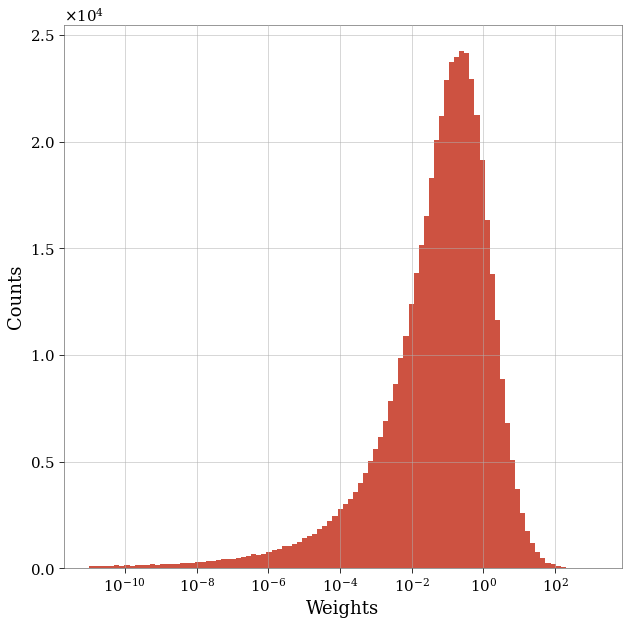

In [113]:
plt.figure(figsize=(10, 10))
hist, bins = np.histogram(weighted_dingo_samples["weights"], bins=100)
a = weighted_dingo_samples["weights"].to_numpy()
a = a[np.nonzero(a)]
print(np.sum(weighted_dingo_samples["weights"] < 1e-2))
print(np.sum(weighted_dingo_samples["weights"] > 1e-2))
logbins = np.logspace(np.log10(bins[0] + 1e-11), np.log10(bins[-1]),len(bins))
print(logbins[0:2])
plt.xscale('log')
plt.ylabel("Counts")
plt.xlabel("Weights")
plt.hist(weighted_dingo_samples["weights"], bins=logbins)
print(hist)

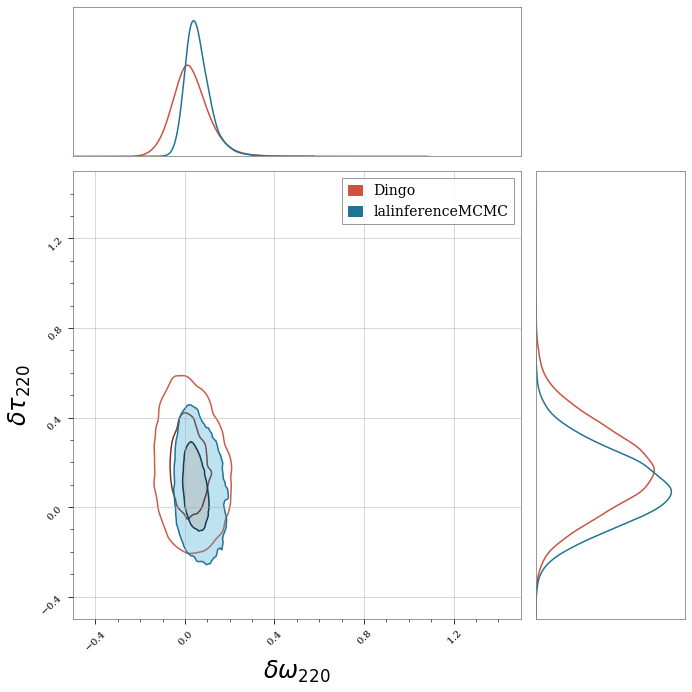

In [114]:
N = 2
c = ChainConsumer()
# c.add_chain(sampler.samples[["domega220", "dtau220"]], color=charizard_hex[0], name='dingo')
c.add_chain(weighted_dingo_samples[["domega220", "dtau220"]].iloc[inds], color=charizard_hex[0], name='dingo', weights=weighted_dingo_samples["weights"].iloc[inds])
c.add_chain(lalinference_samples[["domega220", "dtau220"]], color=charizard_hex[3], name='lalinferenceMCMC', weights=None)
c.configure(
    linestyles=["-"] * N,
    linewidths=[1.5] * N,
    sigmas=[np.sqrt(2) * scipy.special.erfinv(x) for x in [.50, .90]],
    shade=[False] + [True] * (N - 1),
    shade_alpha=0.3,
    bar_shade=False,
    # color_params="weights",
    label_font_size=10,
    tick_font_size=10,
    usetex=False,
    legend_kwargs={"fontsize": 30},
    kde=[None, 0.7],
)

fig = c.plotter.plot(extents={"domega220":(-0.5, 1.5), "dtau220":(-0.5, 1.5)})
fig.set_size_inches(10, 10)
ax = fig.axes[2]
ax.minorticks_on()  
# ax.scatter(dingo_kde_samples["domega220"], dingo_kde_samples["dtau220"], color=charizard_hex[4], s=1)
# ax.scatter(lalinference_samples["domega220"], lalinference_samples["dtau220"], color=charizard_hex[3], s=1)
# ax.plot(tgr_paper_150914["df220"], tgr_paper_150914["dtau220"], c='k', label="from TGR paper")
ax.legend()
ax.set_xlabel(r"$\delta \omega_{220}$", fontsize=24)
ax.set_ylabel(r"$\delta \tau_{220}$", fontsize=24)

dingo_patch = mpatches.Patch(color=charizard_hex[0], label='Dingo')
# paper_patch = mpatches.Patch(color='k', label="from TGR paper")
lalmcmc_patch = mpatches.Patch(color=charizard_hex[3], label="lalinferenceMCMC")
ax.legend(handles=[dingo_patch, lalmcmc_patch], fontsize=14)
# fig.savefig("/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/plots/TGR_comparison_2048_weighted_synthetic_phase.png")

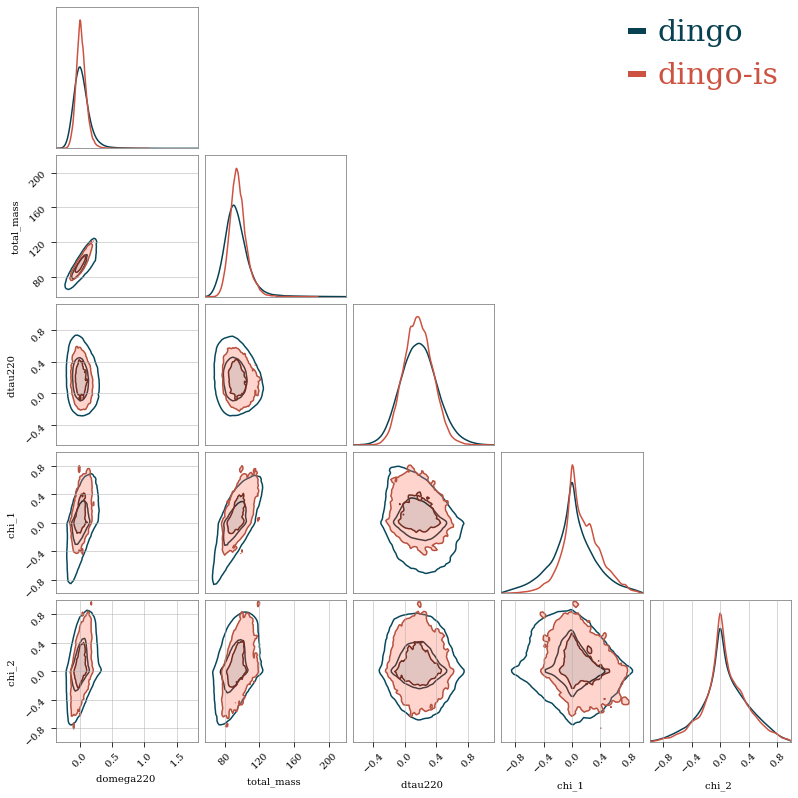

In [115]:
# lalinference_samples["mass_ratio"] = bilby.gw.conversion.component_masses_to_mass_ratio(lalinference_samples["m1"], lalinference_samples["m2"])
# lalinference_samples["chirp_mass"] = bilby.gw.conversion.component_masses_to_chirp_mass(lalinference_samples["m1"], lalinference_samples["m2"])
# lalinference_samples = lalinference_samples.rename(columns={"dist":"luminosity_distance", "time":"geocent_time", "a1z":"chi_1", "a2z":"chi_2", "m1":"mass_1", "m2":"mass_2"})
# lalinference_samples["total_mass"] = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(lalinference_samples["chirp_mass"], lalinference_samples["mass_ratio"])

# lalinference_samples["mass_ratio"] = lalinference_samples["mass_2"] / lalinference_samples["mass_1"]
# lalinference_samples["chirp_mass"] = bilby.gw.conversion.component_masses_to_chirp_mass(lalinference_samples["mass_1"], lalinference_samples["mass_2"])

# Adding mass_1 and mass_2 and total_mass to dingo samples
total_mass = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(weighted_dingo_samples["chirp_mass"], weighted_dingo_samples["mass_ratio"])
weighted_dingo_samples["total_mass"] = total_mass
# weighted_dingo_samples["mass_1"], weighted_dingo_samples["mass_2"] = bilby.gw.conversion.total_mass_and_mass_ratio_to_component_masses(weighted_dingo_samples["mass_ratio"], total_mass)

labels = main_pm_metadata["train_settings"]["data"]["inference_parameters"].copy()
labels.append("total_mass")
labels=["domega220", "total_mass", "dtau220", "chi_1", "chi_2", "mass_ratio"]

# Entire Corner Plot
N = 2
c = ChainConsumer()
# c.add_chain(lalinference_samples[labels], color=charizard_hex[3], name='lalinference_mcmc')
c.add_chain(weighted_dingo_samples[labels], color=charizard_hex[1], name='dingo')
c.add_chain(weighted_dingo_samples[labels], color=charizard_hex[0], name='dingo-is', weights=weighted_dingo_samples["weights"])
# c.add_chain(sampler.samples, color=charizard_hex[0], name='dingo')
c.configure(
    linestyles=["-"] * N,
    linewidths=[1.5] * N,
    sigmas=[np.sqrt(2) * scipy.special.erfinv(x) for x in [0.5, 0.9]],
    shade=[False] + [True] * (N - 1),
    shade_alpha=0.3,
    bar_shade=False,
    label_font_size=10,
    tick_font_size=10,
    usetex=False,
    legend_kwargs={"fontsize": 30},
    kde=[0.7, 0.7]
)

# NOTE prod run for GW150914 only went up to 1024Hz vs here is is on LAL data up to 1024 Hz.
fig = c.plotter.plot(figsize=(12, 12))# extents={"chirp_mass": (10, 30), "total_mass": (30, 120)})
# plt.savefig("/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/plots/full_PE_weighted_synthetic_phase.png")

PP Plot
-------

In [35]:
def make_pp(percentiles, parameter_labels, ks=True):

    percentiles = percentiles / 100.0
    nparams = percentiles.shape[-1]
    nposteriors = percentiles.shape[0]

    ordered = np.sort(percentiles, axis=0)
    ordered = np.concatenate((np.zeros((1, nparams)), ordered, np.ones((1, nparams))))
    y = np.linspace(0, 1, nposteriors + 2)

    fig = plt.figure(figsize=(10, 10))

    for n in range(nparams):
        if ks:
            pvalue = stats.kstest(percentiles[:, n], "uniform")[1]
            plt.step(
                ordered[:, n],
                y,
                where="post",
                label=parameter_labels[n] + r" ({:.3g})".format(pvalue),
            )
        else:
            plt.step(ordered[:, n], y, where="post", label=parameter_labels[n])
    plt.plot(y, y, "k--")
    plt.legend(prop={"size": 15})
    plt.ylabel(r"$CDF(p)$")
    plt.xlim((0, 1))
    plt.ylim((0, 1))

    plt.xlabel(r"$p$")

    ax = fig.gca()
    ax.set_aspect("equal", anchor="SW")

    plt.grid()
    plt.show()

init_sampler = GWSampler(model=time_pm)
sampler = GWSamplerGNPE(model=main_pm, init_sampler=init_sampler, num_iterations=30)

labels = sampler.metadata["train_settings"]["data"]["inference_parameters"]
neval = 100  # number of injections
nparams = len(labels)

n_failed_injections = 0
percentiles = np.empty((neval, nparams))
for idx in range(neval):
    print(idx)
    try:
        strain_data = injection_generator.random_injection()
    except:
        n_failed_injections += 1
        continue
    sampler.context = strain_data.copy()
    sampler.run_sampler(
        num_samples=25_000,
        batch_size=5_000,
    )
    pred = np.stack([sampler.samples[l] for l in labels])
    actual = np.array([strain_data["parameters"][l] for l in labels])

    for n in range(nparams):
        percentiles[idx, n] = stats.percentileofscore(pred[n, :], actual[n])

print(f"failed injections {n_failed_injections}/{neval}")
make_pp(percentiles, labels)

GNPE parameters:  ['H1_time', 'L1_time', 'V1_time']
0
Running sampler to generate 25000 samples.


RuntimeError: CUDA out of memory. Tried to allocate 724.00 MiB (GPU 0; 39.44 GiB total capacity; 25.21 GiB already allocated; 546.50 MiB free; 25.30 GiB reserved in total by PyTorch)

Combining Data From Multiple Injections
---------------------------------------

[0.1342990578748799, 0.23817338182515863]


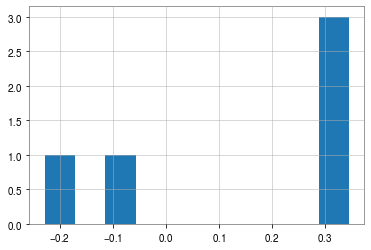

In [ ]:
# Simulate data that is drawn from a gaussian distribution, see if we can recove the "hyperposterior"
n_data_points = 5
injection_parameters = injection_generator.prior.sample(n_data_points)
# So our injection phi is 0, .3
true_phi = [0, .3]
dtau220_injection_values = np.random.normal(loc=true_phi[0], scale=true_phi[1], size=n_data_points)
injection_parameters["dtau220"] = dtau220_injection_values
injection_parameters = [{k:v[i] for k, v in injection_parameters.items()} for i in range(injection_parameters["chirp_mass"].shape[0])]
data = [injection_generator.injection(parameters) for parameters in injection_parameters]
plt.hist([a["dtau220"] for a in injection_parameters])
true_sample_phi = [np.mean(dtau220_injection_values), np.std(dtau220_injection_values)]
print(true_sample_phi)

In [ ]:
# Generating posteriors for the injections
posteriors = {}
for k, v in enumerate(data):
    sampler.context = v
    sampler.run_sampler(num_samples=50_000,batch_size=10_000)
    posteriors[k] = sampler.samples[["dtau220", "domega220"]]
posteriors = {k:np.array([posterior[k].to_numpy() for posterior in posteriors.values()]) for k in posteriors[0].columns}

In [ ]:
# Code developed by Max Isi:
def fit_it(chi_samples, nobs, nsamp, model, niter=2000):
    ''' Carry out Stan population fit for a given parameter ("chi").
    
    Arguments
    ---------
    chi_samples: array
        samples for all events `[[event_1_samples], [event_2_samples] ...]`
    nobs: int
        number of events (i.e. observations).
    nsamp: int
        number of samples per event (subselects for speed).
    model: pystan.StanModel
        stan model.
    niter: int
        number of stan iterations (def. 2000).
    '''
    #samples = [cs[:nsamp] for cs in chi_samples[:nobs]]
    chosen_chi_samples = chi_samples[np.random.choice(range(len(chi_samples)),
                                                      nobs, replace=False)]
    samples = []
    for cs in chosen_chi_samples:
        idxs = np.random.choice(range(len(cs)), nsamp, replace=False)
        samples.append(cs[idxs])
    stan_data = {'nobs': nobs, 'nsamp': nsamp, 'chis': samples}
    return model.sampling(data=stan_data, iter=niter)

def fit_all(data, fits=None, max_nsamples=1000,
            scale_factors=None, **kwargs):
    ''' Fit a series of parameters, if fit not already in `fits`.
    
    Arguments
    ---------
    data: dict
        dictionary with individual-event samples for each parameter.
    fits: dict
        dictionary with population fit results.
    cache: str
        path template to cache fit results.
    max_nsamples: int
        maximum number of individual-event samples used in population fit.
    scale_factors: dict
        optionally scale parameters (x -> x/scale) to bring it into unit
        range; the keys must be names of parameters to rescale. (The scaling
        is undone before returning the result.)
        
    Returns
    -------
    fits: dict
        dictionary with fit results.
    '''
    if fits is None:
        fits = {}
    if scale_factors is None:
        scale_factors = {k: 1 for k in data.keys()}
    failed = []
    for label, chi_samples_dict in data.items():
        if label not in fits:
            chi_samples = np.array(list(chi_samples_dict.values()))
            # rescale samples by some scalar to ease sampling
            sf = scale_factors.get(label, 1.0)
            chi_samples /= sf
            # number of observations (events)
            no = len(chi_samples_dict)
            # number of posterior samples
            nsamples = [len(s) for s in chi_samples]
            ns = min(min(nsamples), max_nsamples)
            if no > 0:
                fit = fit_it(chi_samples, no, ns, **kwargs)
                # restore original scale to the data
                fits[label] = {k: fit[k]*sf for k in ['mu', 'sigma', 'pop']}
            else:
                print("WARNING: no data for %s" % label)
                failed.append(label)
    return fits

def save_cache(fits, cache_path, paths=None):
    for param, fit in fits.items():
        try:
            post = fit.extract(['mu', 'sigma', 'pop'])
        except AttributeError:
            post = fit
        for k in ['mu', 'sigma', 'pop']:
            np.savetxt(cache_path.format(par=param, hyper=k), post[k])
        print("Cached %s"%  param)
    # record list of events
    if paths:
        cache_dir = os.path.dirname(cache_path)
        log_path = os.path.join(cache_dir, 'events.json')
        with open(log_path, 'w') as f:
            json.dump(paths, f, indent=4)
        print("Events logged: %r" % log_path)
     

model = pystan.StanModel(file='/home/local/nihargupte/dingo-devel/tutorials/06_tgr/src/hier_gr.stan')
cache_path = "/home/local/nihargupte/dingo-devel/tutorials/06_tgr/dumps/pystan"
# Fit it! (only if needed: `fit_all` checks whether fit already exists)
# data ?= {"domega220":np.array[[event_1_samples], [event_2_samples] ...], "dtau220":[[samples1], [samples2]]}
fits = fit_all(posteriors, model=model)
save_cache(fits, cache_path)

Combining Data From Multiple Injections
---------------------------------------

[0.1595227550768951, 0.0]


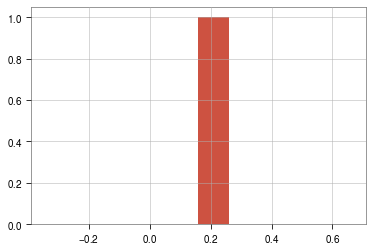

In [ ]:
# Simulate data that is drawn from a gaussian distribution, see if we can recove the "hyperposterior"
n_data_points = 1
injection_parameters = injection_generator.prior.sample(n_data_points)
# So our injection phi is 0, .3
true_phi = [0, .3]
dtau220_injection_values = np.random.normal(loc=true_phi[0], scale=true_phi[1], size=n_data_points)
injection_parameters["dtau220"] = dtau220_injection_values
injection_parameters = [{k:v[i] for k, v in injection_parameters.items()} for i in range(injection_parameters["chirp_mass"].shape[0])]
data = [injection_generator.injection(parameters) for parameters in injection_parameters]
plt.hist([a["dtau220"] for a in injection_parameters])
true_sample_phi = [np.mean(dtau220_injection_values), np.std(dtau220_injection_values)]
print(true_sample_phi)

In [ ]:
def get_kde(samples):
    """Given samples return the 1D kde"""
    # Generate 100_000 points and use that as a KDE
    kde = scipy.stats.gaussian_kde(samples)
    return kde

def get_unnormalized_phi_given_data(data, sampler, param, phi, integral_granularity = 100):
    theta_points = np.linspace(
    eval(sampler.metadata["dataset_settings"]["intrinsic_prior"][param]).minimum,
    eval(sampler.metadata["dataset_settings"]["intrinsic_prior"][param]).maximum,
    integral_granularity,
    )
    dtheta = (eval(sampler.metadata["dataset_settings"]["intrinsic_prior"][param]).maximum - eval(sampler.metadata["dataset_settings"]["intrinsic_prior"][param]).minimum) / integral_granularity

    unnormalized_prob_phi_given_data = 1
    gaussian = scipy.stats.norm(loc=phi[0], scale=phi[1])
    for d in data:
        sampler.context = d
        sampler.run_sampler(num_samples=10_000,batch_size=10_000)
        # Sample 
        posterior_kde = get_kde(sampler.samples[param])
        
        unnormalized_prob_d_given_phi = 0
        for theta in theta_points:
            prob_theta_given_phi = gaussian.pdf(theta)
            prob_d_given_theta = posterior_kde.pdf(theta)[0]
            unnormalized_prob_d_given_phi += prob_theta_given_phi * prob_d_given_theta * dtheta
        unnormalized_prob_phi_given_data *= unnormalized_prob_d_given_phi
    return unnormalized_prob_phi_given_data

param = "dtau220"
# Defining grid granularity
phi_grid_granularity = 5
# mu, sigma prior, these two toghether define phi
mu_prior = bilby.core.prior.Uniform(-0.5, 0.5)
sigma_prior = bilby.core.prior.Uniform(0.01, 0.7)

# Very naive approach just evaluating the integral numerically on a grid, will take forever
# Creating a grid of points according to prior on phi
mu = np.linspace(mu_prior.minimum, mu_prior.maximum, phi_grid_granularity)
dmu = (mu_prior.maximum - mu_prior.minimum) / phi_grid_granularity
sigma = np.linspace(sigma_prior.minimum, sigma_prior.maximum, phi_grid_granularity)
dsigma = (sigma_prior.maximum - sigma_prior.minimum) / phi_grid_granularity
mu, sigma = np.meshgrid(mu, sigma)
mu = mu.flatten()
sigma = sigma.flatten()

# unnormalized_prob_phi_given_data = []
# for mu_i, sigma_i in zip(mu, sigma):
#     print(mu_i, sigma_i)
#     unnormalized_prob_phi_given_data.append(get_unormalized_phi_given_data(data, sampler, param, [mu_i, sigma_i]))
# unnormalized_prob_phi_given_data = np.array(unnormalized_prob_phi_given_data)

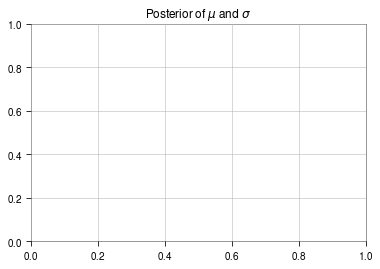

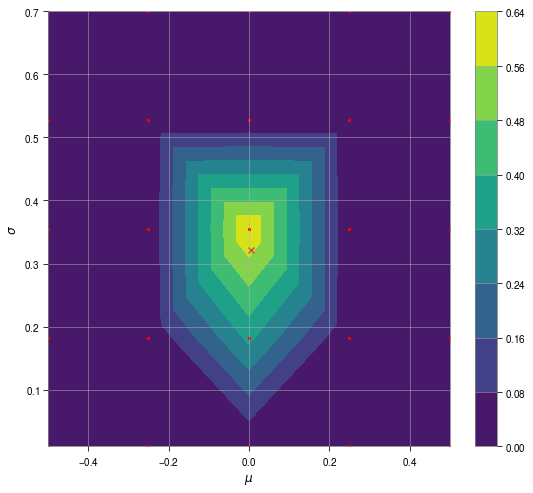

In [ ]:
prob_phi_given_data = unnormalized_prob_phi_given_data / np.sum(unnormalized_prob_phi_given_data)
plt.title(r"Posterior of $\mu$ and $\sigma$")
plt.figure(figsize=(9, 8))
plt.xlabel(r"$\mu$")
plt.ylabel(r"$\sigma$")
ax = plt.tricontourf(mu, sigma, prob_phi_given_data)
plt.scatter(true_sample_phi[0], true_sample_phi[1], marker='x')
plt.scatter(mu, sigma, s=5, c='r')
plt.colorbar(ax)

Using PyMC to speed up computation of P(\phi | {data})

In [ ]:
import dynesty

# Using dynesty to sample, tbh dynesty expects a normalized liklihood so idk how well this is gonna work, but mathematically the normalization between the posterior and 
# the liklihood should be absorbed into the overal normalization factor so in principle it should be possible
def get_log_unnormalized_phi_given_data(data, sampler, param, phi, integral_granularity = 100):
    return np.log(get_unnormalized_phi_given_data(data, sampler, param, phi, integral_granularity=integral_granularity))

def prior(u):
    a = 1. * (2. * u[0] - 1.)
    b = 1. * u[1]
    return np.array([a, b])

loglike = partial(get_log_unnormalized_phi_given_data, data, sampler, "dtau220")
# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike, prior, 2, print_progress=True)
# sampler.run_nested()
# sresults = sampler.results

Exception while calling loglikelihood function:
  params: [-0.08927524  0.7678287 ]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/local/nihargupte/tgr/venv/lib/python3.9/site-packages/dynesty/dynesty.py", line 939, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_2265708/1808631330.py", line 6, in get_log_unnormalized_phi_given_data
    return np.log(get_unnormalized_phi_given_data(data, sampler, param, phi, integral_granularity=integral_granularity))
  File "/tmp/ipykernel_2265708/3577302632.py", line 9, in get_unnormalized_phi_given_data
    eval(sampler.metadata["dataset_settings"]["intrinsic_prior"][param]).minimum,
AttributeError: 'MultiEllipsoidSampler' object has no attribute 'metadata'


AttributeError: 'MultiEllipsoidSampler' object has no attribute 'metadata'

In [ ]:
def metropolis_Gaussian(p, z0, std, n_samples=100, burn_in=0, m=1, prior=None):
    """
    Metropolis Algorithm using a Gaussian proposal distribution.
    p: distribution that we want to sample from (can be unnormalized)
    z0: Initial sample
    std: standard deviation of the proposal normal distribution.
    n_samples: number of final samples that we want to obtain.
    burn_in: number of initial samples to discard.
    m: this number is used to take every mth sample at the end
    """
    # Pre-allocate memory for samples (much more efficient than using append)
    samples = np.zeros(shape=(n_samples, 2))

    # Store initial value
    samples[0] = z0
    z = z0
    # Compute the current likelihood
    l_cur = p(z)

    # Counter
    iter = 0
    # Total number of iterations to make to achieve desired number of samples
    iters = (n_samples * m) + burn_in

    # Sample outside the for loop
    innov = np.random.normal(loc=0, scale=std, size=(iters, 2))
    u = np.random.rand(iters)

    while iter < iters:
        # Random walk innovation on z
        cand = z + innov[iter]
        # Compute candidate likelihood
        l_cand = p(cand)

        # Accept or reject candidate
        if l_cand / l_cur > u[iter] and check_prior(cand, prior):
            z = cand
            print(z)
            l_cur = l_cand

        # Only keep iterations after burn-in and for every m-th iteration
        if iter > burn_in and iter % m == 0:
            samples[(iter - burn_in) // m] = z

        iter += 1

    return samples

def check_prior(sample, prior):
    if prior == None:
        return True
    return np.all([sample[i] < prior[i].maximum and sample[i] > prior[i].minimum for i in range(len(prior))])

p = partial(get_unnormalized_phi_given_data, data, sampler, "dtau220")
samples = metropolis_Gaussian(p, z0=np.array([0, 0.3]), n_samples=1_000, std=.1, burn_in=100, prior=[mu_prior, sigma_prior])
    

[-0.24201113  0.10764854]
[-0.25071716  0.10563146]
[-0.16993953  0.04873866]
[-0.18920385  0.08155334]
[-0.26743612  0.14214402]
[-0.42927715  0.17814507]
[-0.33462285  0.12003599]
[-0.37811671  0.17725802]
[-0.36522464  0.2108195 ]
[-0.39302138  0.1839453 ]
[-0.21924408  0.23912015]
[-0.14492121  0.27229143]
[-0.22359132  0.30464289]
[-0.26414294  0.286814  ]
[-0.17005115  0.32431913]
[-0.03149974  0.43226486]
[-0.14785605  0.56462747]
[-0.15197316  0.5705168 ]
[-0.17889889  0.50123461]
[-0.0706202   0.51492687]
[0.02395632 0.39842711]
[0.11485452 0.31824235]
[0.1550117  0.38986162]
[0.17640109 0.49128587]
[0.22218091 0.48396225]
[0.24958852 0.60615192]
[0.27619294 0.62864894]
[0.35299719 0.58572011]
[0.40909033 0.58497675]
[0.35198685 0.6582349 ]
[0.40496502 0.62728012]
[0.47511057 0.62848707]
[0.46852847 0.65238513]
[0.42328831 0.43063797]
[0.37487741 0.243349  ]
[0.35671844 0.27382055]
[0.25577755 0.10743901]
[0.2844818 0.1457867]
[0.19375271 0.09169681]
[0.23961097 0.33508761]
[0

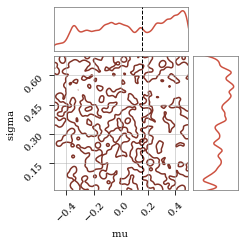

In [ ]:
N = 1
c = ChainConsumer()
c.add_chain({"mu": samples[:, 0], "sigma": samples[:, 1]}, color=charizard_hex[0], name='dingo')
c.configure(
    linestyles=["-"] * N,
    linewidths=[1.5] * N,
    sigmas=[np.sqrt(2) * scipy.special.erfinv(x) for x in [.9]],
    shade=[False] + [True] * (N - 1),
    shade_alpha=0.3,
    bar_shade=False,
    label_font_size=10,
    tick_font_size=10,
    usetex=False,
    legend_kwargs={"fontsize": 30},
    # kde=0.7
)

fig = c.plotter.plot(truth={"mu":true_sample_phi[0], "sigma":true_sample_phi[1]})

In [ ]:
from bilby.core.prior import Constraint
param_keys = [k for k, v in sampler.prior.items() if not isinstance(v, Constraint)]
theta = sampler.samples[param_keys][1000:1100]
constraints = np.array([sampler.prior.evaluate_constraints(t) for _, t in theta.iterrows()])
print(constraints)
((50_000 / 100) * 1.3) / 60

In [ ]:
from line_profiler import LineProfiler
lp = LineProfiler()
lp_wrapper = lp(get_unormalized_phi_given_data)
lp_wrapper(data, sampler, param, [mu_i, sigma_i])
lp.print_stats()

Timer unit: 1e-06 s

Total time: 22.088 s
File: /tmp/ipykernel_1596441/1336958928.py
Function: get_unormalized_phi_given_data at line 7

Line #      Hits         Time  Per Hit   % Time  Line Contents
     7                                           def get_unormalized_phi_given_data(data, sampler, param, phi, integral_granularity = 100):
     8         2        180.0     90.0      0.0      theta_points = np.linspace(
     9         1         92.0     92.0      0.0      eval(sampler.metadata["dataset_settings"]["intrinsic_prior"][param]).minimum,
    10         1         45.0     45.0      0.0      eval(sampler.metadata["dataset_settings"]["intrinsic_prior"][param]).maximum,
    11         1          1.0      1.0      0.0      integral_granularity,
    12                                               )
    13         1         89.0     89.0      0.0      dtheta = (eval(sampler.metadata["dataset_settings"]["intrinsic_prior"][param]).maximum - eval(sampler.metadata["dataset_settings"]["in

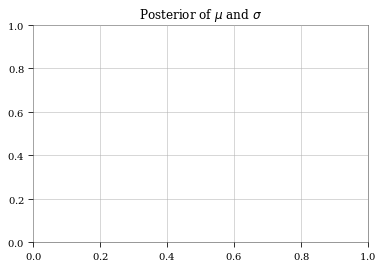

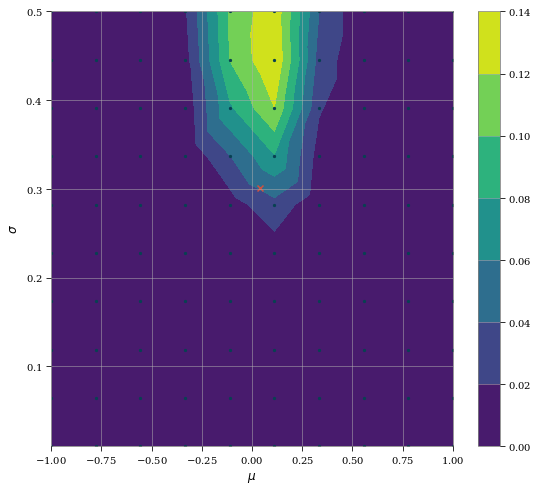

In [ ]:
prob_phi_given_data = unnormalized_prob_phi_given_data / np.sum(unnormalized_prob_phi_given_data)
plt.title(r"Posterior of $\mu$ and $\sigma$")
plt.figure(figsize=(9, 8))
plt.xlabel(r"$\mu$")
plt.ylabel(r"$\sigma$")
ax = plt.tricontourf(mu, sigma, prob_phi_given_data)
plt.scatter(true_sample_phi[0], true_sample_phi[1], marker='x')
plt.scatter(mu, sigma, s=5)
plt.colorbar(ax)
plt.savefig("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/plots/mu_sigma_posterior.png")

In [ ]:
# Now marginalizing over the region to find P(dtau220 | {data})
theta_granularity = 100
param = "dtau220"
theta = np.linspace(
eval(sampler.metadata["dataset_settings"]["intrinsic_prior"][param]).minimum,
eval(sampler.metadata["dataset_settings"]["intrinsic_prior"][param]).maximum,
theta_granularity,
)

prob_theta_given_data = []
for theta_i in theta:
    integral = 0
    for idx, (mu_i, sigma_i) in enumerate(zip(mu, sigma)):
        prob_theta_given_phi = scipy.stats.norm(loc=mu_i, scale=sigma_i).pdf(theta_i)
        print(theta_i, mu_i, sigma_i, prob_theta_given_phi, prob_phi_given_data[idx])
        integral += prob_theta_given_phi * prob_phi_given_data[idx] * dmu * dsigma
    prob_theta_given_data.append(integral)

-0.8 -1.0 0.01 5.520948362160077e-86 0.0
-0.8 -0.7777777777777778 0.01 3.3773651035270413 5.044649869097187e-05
-0.8 -0.5555555555555556 0.01 7.058810481358008e-129 2.3487662352236243e-15
-0.8 -0.33333333333333337 0.01 0.0 1.3874628281807163e-12
-0.8 -0.11111111111111116 0.01 0.0 1.0603371716904107e-12
-0.8 0.11111111111111116 0.01 0.0 3.701930405159796e-06
-0.8 0.33333333333333326 0.01 0.0 5.308102849919897e-07
-0.8 0.5555555555555554 0.01 0.0 8.507052323532387e-11
-0.8 0.7777777777777777 0.01 0.0 2.8454468654829447e-13
-0.8 1.0 0.01 0.0 1.275078270447476e-16
-0.8 -1.0 0.06444444444444444 0.050152727415302946 4.0224663245648263e-32
-0.8 -0.7777777777777778 0.06444444444444444 5.833167641062037 1.7072091645367386e-07
-0.8 -0.5555555555555556 0.06444444444444444 0.004650392450031656 1.917999256965567e-13
-0.8 -0.33333333333333337 0.06444444444444444 2.541265243485392e-11 2.1048819122532905e-11
-0.8 -0.11111111111111116 0.06444444444444444 9.518875212427067e-25 1.1256192081914465e-08
-0.

In [3]:
import lal 
from gwpy.timeseries import TimeSeries
import yaml
from lalframe.frread import read_timeseries
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Junk code
cache = lal.CacheImport("/home/nihargupte.HYPATIA/runs/GW150914_2/caches/H-H1_HOFT_C02_CACHE-1126259184-297.lcf")
# ok so need channels, gpsstart, psddatalength
channel = "H1_HOFT_C02"
gps_start = 1126259462.391
psd_data_length = 240.0
T_PSD = psd_data_length
sample_rate=4096.0
segment_length = int(8.0)
padding = 0.4
seglen = int(segment_length*sample_rate)

# Somehow we need to get the subset of strain and not the whole thing via the .lcf cache?
time_psd = 1024
time_buffer = 2.0
time_event = 1126259462.391

# # lalinference_strain_data_L1.plot()
time_segment = 8.0
start_time = time_event + time_buffer - time_segment
end_time = time_event + time_buffer

print(psd_data_length, segment_length)
n_segs = psd_data_length/segment_length

# Function get PSD from .gwf file
# NOTE WE SHOULD BE GETTING THE CACHE HERE AND NOT THE TIME SERIES!
lalinference_strain_data_L1 = TimeSeries.read("/home/nihargupte.HYPATIA/data/frame_files/GW150914/L-L1_HOFT_C02-1126256640-4096.gwf", "L1:DCS-CALIB_STRAIN_C02")
lalinference_strain_data_H1 = TimeSeries.read("/home/nihargupte.HYPATIA/data/frame_files/GW150914/H-H1_HOFT_C02-1126256640-4096.gwf", "H1:DCS-CALIB_STRAIN_C02")

240.0 8


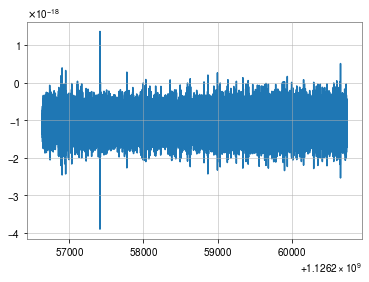

In [3]:
strain = lalinference_strain_data_L1
# slice_idxs = [np.argmin(np.abs(np.array(strain.times) - start_time)), np.argmin(np.abs(np.array(strain.times) - end_time))]
# strain = strain[slice_idxs[0]:slice_idxs[1]]
strain = strain.resample(rate=4096)
lalinference_strain = lal.CreateREAL8TimeSeries(
    strain.name,
    strain.t0.value,
    0,
    strain.dt.value,
    None,
    strain.shape[0],
)
lalinference_strain.data.data = np.array(strain)
times = np.arange(0, lalinference_strain.deltaT*lalinference_strain.data.data.shape[0], lalinference_strain.deltaT) + lalinference_strain.epoch
plt.plot(times, lalinference_strain.data.data)

(16385,)


/data/nihargupte/projects/dingo-devel/tgr_venv/lib/python3.8/site-packages/matplotlib_inline/backend_inline.py:234: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


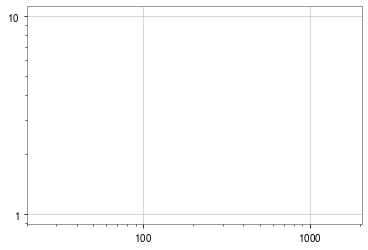

In [4]:
t_length = strain.shape[0]*strain.dt
n_psds, _ = divmod(t_length.value, T_PSD)
starts, stops = [n*int(seglen*n_segs) for n in range(int(n_psds))], [(n+1)*int(seglen*n_segs) for n in range(int(n_psds))]
strain = lalinference_strain_data_L1
strain = strain.resample(rate=4096)
lalinference_strain = lal.CreateREAL8TimeSeries(
    strain.name,
    strain.t0.value,
    0,
    strain.dt.value,
    None,
    strain.shape[0],
)
lalinference_strain.data.data = np.array(strain)
times = np.arange(0, lalinference_strain.deltaT*lalinference_strain.data.data.shape[0], lalinference_strain.deltaT)
lalinference_strain = lal.ShrinkREAL8TimeSeries(lalinference_strain, starts[16], stops[16])
one_sided_noise_power_spectrum = lal.CreateREAL8FrequencySeries("spectrum", lalinference_strain.epoch, 0.0, sample_rate/seglen , None, int(seglen/2 +1))

# Setting up FFT structures
time_to_freq_FFT_plan = lal.CreateForwardREAL8FFTPlan(seglen, 1)
# Setting up window
if 2.0*padding*sample_rate/seglen < 0.0 or 2.0*padding*sample_rate/seglen >1:
    print("Padding is negative or 2*padding is bigger than the whole segment. Consider reducing it using --padding or increase --seglen. Exiting\n")
window = lal.CreateTukeyREAL8Window(seglen, 2.0*padding*sample_rate / seglen)

spectrum_median_psd = one_sided_noise_power_spectrum
welch_psd = one_sided_noise_power_spectrum.__copy__()
# Looks like they give the same result regardless...
lal.REAL8AverageSpectrumMedian(spectrum_median_psd, lalinference_strain, seglen, int(seglen), window, time_to_freq_FFT_plan)
lal.REAL8AverageSpectrumWelch(welch_psd, lalinference_strain, seglen, int(seglen), window, time_to_freq_FFT_plan)

freqs = np.arange(0, one_sided_noise_power_spectrum.deltaF*one_sided_noise_power_spectrum.data.data.shape[0], one_sided_noise_power_spectrum.deltaF) + one_sided_noise_power_spectrum.f0
print(one_sided_noise_power_spectrum.data.data.shape)
plt.xlim([20, 2048])
plt.xscale('log')
plt.yscale('log')
plt.plot(freqs, spectrum_median_psd.data.data - welch_psd.data.data)

In [5]:
import glob
from dingo.gw.gwutils import get_window

files = glob.glob("/data/nihargupte/datasets/O1/H1_HOFT_C02" + '/**/*.gwf', recursive=True)
len(files)

2705

In [6]:
from dingo.gw.ASD_dataset.dataset_utils import estimate_PSDs_from_gwf, create_dataset_from_files, get_valid_segments, get_valid_gwf_segments

# Testing my function for generating PSDs from a GWF file
with open("/data/nihargupte/datasets/ASDs/2048_all/settings.yaml", "r") as f:
    settings = yaml.safe_load(f)
settings = settings["dataset_settings"]
# estimate_PSDs_from_gwf(
#     data_dir="/data/nihargupte/datasets/ASDs/2048_all",
#     gwf_filename=files[0],
#     channel="H1:DCS-CALIB_STRAIN_C02",
#     settings=settings,
# )

In [7]:
from dingo.gw.ASD_dataset.dataset_utils import estimate_PSDs_from_gwf, create_dataset_from_files, get_valid_segments, estimate_PSDs_from_gwfs
import requests
from io import StringIO

url = "https://www.gw-openscience.org/timeline/segments/O1/H1_BURST_CAT2/1126051217/11203200/"
r = requests.get(url, allow_redirects=True)
c = StringIO(r.content.decode("utf-8"))
starts_seg, stops_seg, durations_seg = np.loadtxt(c, dtype="int", unpack=True)
segs = np.stack([starts_seg, stops_seg, durations_seg]).T
segs = segs[segs[:, 2] >= T_PSD]
segs = segs[:, :2]

In [8]:
# Function which takes folder and gives GPS time range of each file along with filename
import re

file_times = pd.DataFrame(columns=["file_name", "gps_start", "gps_end"])
for i, file in enumerate(files):
    gps_start_time, duration = re.findall(r'\b\d+\b', os.path.basename(file))
    gps_start_time, duration = float(gps_start_time), float(duration)
    df = pd.DataFrame({"file_name": [file], "gps_start": [gps_start_time], "gps_end": [gps_start_time + duration]})
    file_times = pd.concat([file_times, df])
file_times = file_times.sort_values(by=["gps_start"])
segs = np.sort(segs, axis=0)

In [9]:
intersection_segments = get_valid_gwf_segments(file_times, segs)

Text(0, 0.5, 'Index')

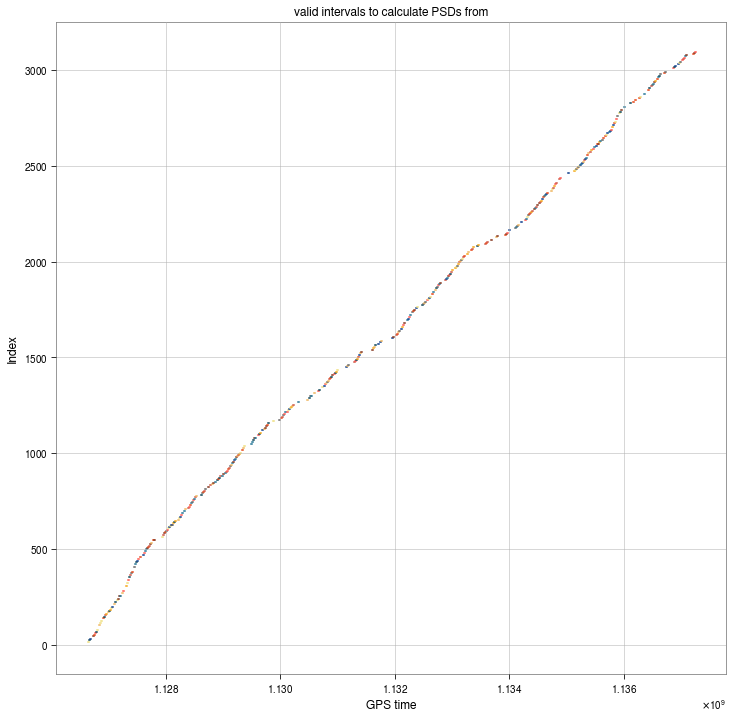

In [11]:
plt.figure(figsize=(12, 12))
for i, (_, row) in enumerate(intersection_segments.iterrows()):
    plt.plot([row["segment_start"], row["segment_end"]], [i, i])

plt.title("valid intervals to calculate PSDs from")
plt.xlabel("GPS time")
plt.ylabel("Index")

In [39]:
file = intersection_segments.iloc[0]["file_name"]
seg = (intersection_segments.iloc[0]["segment_start"], intersection_segments.iloc[0]["segment_end"])
estimate_PSDs_from_gwf(data_dir="/data/nihargupte/datasets/ASDs/test", gwf_filename=file, channel="H1:DCS-CALIB_STRAIN_C02", detector="H1", settings=settings, valid_segment=seg)


Loading dataset from /data/nihargupte/datasets/ASDs/O1/2048_dingo/asds_O1.hdf5.


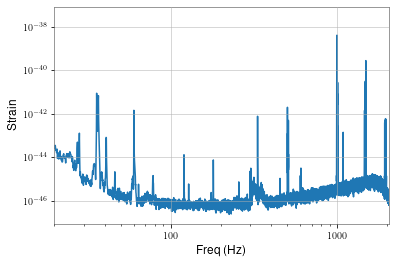

In [41]:
psd = np.load("/data/nihargupte/datasets/ASDs/test/tmp/raw_PSDs/O1/H1/240_0/psd_00000.npy", allow_pickle=True).item()
psd = psd["psd"]
asd_dataset = ASDDataset(file_name="/data/nihargupte/datasets/ASDs/O1/2048_dingo/asds_O1.hdf5")
# freqs = np.arange(0, psd.deltaF*psd.data.data.shape[0], psd.deltaF) + psd.f0
plt.xlabel("Freq (Hz)")
plt.ylabel("Strain")
plt.xlim([20, 2048])
plt.xscale('log')
plt.yscale('log')
plt.plot(asd_dataset.domain.sample_frequencies, psd)

In [13]:
with open("/data/nihargupte/datasets/ASDs/test/settings.yaml", "r") as f:
    settings = yaml.safe_load(f)
estimate_PSDs_from_gwfs("/data/nihargupte/datasets/ASDs/test", settings["dataset_settings"])

file_name    /data/nihargupte/datasets/O1/H1_HOFT_C02/H/112...
gps_start                                         1126621184.0
gps_end                                           1126625280.0
Name: 0, dtype: object
[1126073529 1126075221] (1637, 2)
/data/nihargupte/datasets/O1/H1_HOFT_C02/H/1130/H-H1_HOFT_C02-1130946560-4096.gwf (1130946560.0, 1130947695)
file_name    /data/nihargupte/datasets/O1/L1_HOFT_C02/L/112...
gps_start                                         1126621184.0
gps_end                                           1126625280.0
Name: 0, dtype: object
[1126072156 1126078887] (714, 2)
/data/nihargupte/datasets/O1/L1_HOFT_C02/L/1133/L-L1_HOFT_C02-1133457408-4096.gwf (1133457408.0, 1133457951)
[(1130946560.0, 1130947695), (1133457408.0, 1133457951)]
H1 and L1 segments do not match {(1133457408.0, 1133457951), (1130946560.0, 1130947695)}


In [13]:
asd_dataset.asds["H1"][330], asd_dataset.gps_times["H1"][330]
asd = {"H1": asd_dataset.asds["H1"][330], "L1": asd_dataset.asds["L1"][330]}
gps_times = {"H1": asd_dataset.gps_times["H1"][330], "L1": asd_dataset.gps_times["L1"][330]}
asd, gps_times

NameError: name 'asd_dataset' is not defined

In [42]:
dictionary = {
    "settings": asd_dataset.settings,
    "asds": {k:v.reshape(1, -1) for k, v in asd.items()},
    "gps_times": gps_times
}
new_asd_dataset = ASDDataset(dictionary=dictionary)
new_asd_dataset.to_file(file_name="/data/nihargupte/datasets/ASDs/O3/2048/asds_O3_fixed.hdf5")

Saving dataset to /data/nihargupte/datasets/ASDs/O3/2048/asds_O3_fixed.hdf5


In [37]:
new_asd_dataset = ASDDataset(file_name="/data/nihargupte/datasets/ASDs/O3//asds_O3_fixed.hdf5")
new_asd_dataset.sample_random_asds()


Loading dataset from /data/nihargupte/datasets/ASDs/O3/1024/asds_O3_fixed.hdf5.


{'H1': array([6.83475162e-24, 9.97592207e-24, 1.20671440e-23, ...,
        9.81360729e-26, 9.87567843e-26, 5.52583935e-26]),
 'L1': array([1.65385046e-23, 2.93915255e-23, 3.62957296e-23, ...,
        6.12298796e-26, 6.68739056e-26, 3.88993469e-26])}